## 2. Decision Tree to Predict Loan Defaults
#### We will consider a simplified subset of the Lending Club Loan Data available on Kaggle (https://www.kaggle.com/wendykan/lending-club-loan-data). Using ideas from a Kaggle Kernel by Kacper Wozniak, we have preprocessed the dataset the following steps:
* **Removed any column that has more than 50% of the observations missing**
* **Removed any row with at least one missing value**
* **Removed any loans that are not Fully Paid or Charged Off (defaulted)**
* **Only used individual applicants (i.e., join types are ignored)**
* **Removed columns referring to “Active” loan accounts, joint applicants, or with too many unique values that preprocessing may take longer than necessary (i.e., policy code, employee title)**
* **Convert the loan status to binary variable (class) as Fully Paid (0) vs Charged Off (1)**
* **Subsample the data for a smaller dataset**
#### The resulting dataset (loan default.csv) contains 2850 loans with 26 features. Use your favorite decision tree package, or implement your own, to predict the loan status.

#### (a) Pre-processing: Split the data into a train / test split (justify your selection). Specify any additional pre-processing you performed on the dataset.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_csv("loan_default.csv", index_col=0)
df.isna().any()

loan_amnt                     False
term                          False
int_rate                      False
installment                   False
grade                         False
emp_length                     True
home_ownership                False
annual_inc                    False
verification_status           False
purpose                       False
dti                           False
delinq_2yrs                   False
earliest_cr_line              False
inq_last_6mths                False
open_acc                      False
pub_rec                       False
revol_bal                     False
revol_util                    False
total_acc                     False
recoveries                    False
collections_12_mths_ex_med    False
acc_now_delinq                False
tot_coll_amt                  False
tot_cur_bal                   False
total_rev_hi_lim              False
class                         False
dtype: bool

In [5]:
# Fill out NA on emp_length feature with 5 years
df['emp_length'] = df['emp_length'].fillna('5 years')

In [6]:
df.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,...,revol_bal,revol_util,total_acc,recoveries,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,class
182791,8000,36 months,14.09,273.78,B,10+ years,RENT,112000.0,Not Verified,wedding,...,19340,66.0,22,0.0,0,0,0,37551,29302.0,0
65813,8000,36 months,7.90,250.33,A,10+ years,OWN,65000.0,Not Verified,debt_consolidation,...,11774,15.0,25,0.0,0,0,0,60643,78400.0,0
826148,15000,60 months,13.99,348.95,C,10+ years,MORTGAGE,109000.0,Not Verified,major_purchase,...,32538,99.2,28,0.0,0,0,0,276506,32800.0,0
278921,13800,36 months,9.17,439.93,B,6 years,MORTGAGE,80000.0,Verified,debt_consolidation,...,8573,15.9,66,0.0,0,0,0,346871,53900.0,0
330821,12000,36 months,8.39,378.20,A,1 year,OWN,55000.0,Not Verified,debt_consolidation,...,10713,36.1,49,0.0,0,0,0,89729,29700.0,0


In [7]:
df.dtypes

loan_amnt                       int64
term                           object
int_rate                      float64
installment                   float64
grade                          object
emp_length                     object
home_ownership                 object
annual_inc                    float64
verification_status            object
purpose                        object
dti                           float64
delinq_2yrs                     int64
earliest_cr_line               object
inq_last_6mths                  int64
open_acc                        int64
pub_rec                         int64
revol_bal                       int64
revol_util                    float64
total_acc                       int64
recoveries                    float64
collections_12_mths_ex_med      int64
acc_now_delinq                  int64
tot_coll_amt                    int64
tot_cur_bal                     int64
total_rev_hi_lim              float64
class                           int64
dtype: objec

Some columns have type 'object'; convert them to type int first.

In [8]:
# Print the values of type object
print(df["term"].value_counts())
print(df["grade"].value_counts())
print(df["emp_length"].value_counts())
print(df["home_ownership"].value_counts())
print(df["verification_status"].value_counts())
print(df["purpose"].value_counts())
print(df["earliest_cr_line"].value_counts())

 36 months    2157
 60 months     693
Name: term, dtype: int64
B    816
C    806
D    519
A    350
E    227
F    100
G     32
Name: grade, dtype: int64
10+ years    980
5 years      309
2 years      223
3 years      222
< 1 year     208
4 years      174
6 years      160
1 year       159
7 years      151
8 years      144
9 years      120
Name: emp_length, dtype: int64
MORTGAGE    1472
RENT        1126
OWN          252
Name: home_ownership, dtype: int64
Verified           1075
Not Verified        908
Source Verified     867
Name: verification_status, dtype: int64
debt_consolidation    1754
credit_card            609
home_improvement       153
other                  143
major_purchase          49
car                     28
medical                 27
small_business          22
house                   20
moving                  19
vacation                17
wedding                  7
renewable_energy         2
Name: purpose, dtype: int64
Jun-2000    27
Jan-2002    27
Oct-2001    26
Aug-2000

In [9]:
# Encode ordinal features
df['term'] = df['term'].astype('category').cat.codes

df['grade'] = df['grade'].astype('category').cat.codes

df['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df['emp_length'] = df['emp_length'].astype('int64')

df['earliest_cr_line'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df['earliest_cr_line'] = df['earliest_cr_line'].astype('int64')

dict_cat = {
    'verification_status': {
        'Not Verified': 0,
        'Source Verified': 1,
        'Verified': 2
    }
}
df.replace(dict_cat, inplace=True)

In [10]:
# Encode non-ordinal features

# Merge small and similar categories
dict_cat = {
    'purpose': {
        'wedding': 'vacation',
        'renewable_energy': 'other'
    }
}
df.replace(dict_cat, inplace=True)

df = pd.get_dummies(df, columns=["home_ownership"])
df = pd.get_dummies(df, columns=["purpose"])

df.dtypes

loan_amnt                       int64
term                             int8
int_rate                      float64
installment                   float64
grade                            int8
emp_length                      int64
annual_inc                    float64
verification_status             int64
dti                           float64
delinq_2yrs                     int64
earliest_cr_line                int64
inq_last_6mths                  int64
open_acc                        int64
pub_rec                         int64
revol_bal                       int64
revol_util                    float64
total_acc                       int64
recoveries                    float64
collections_12_mths_ex_med      int64
acc_now_delinq                  int64
tot_coll_amt                    int64
tot_cur_bal                     int64
total_rev_hi_lim              float64
class                           int64
home_ownership_MORTGAGE         uint8
home_ownership_OWN              uint8
home_ownersh

In [11]:
# Get features and label after converting categorical features
y = df['class'].values
X = df.drop(columns='class').values

In [12]:
# Split training and test set
test_ratio = 0.2

idx_random = np.arange(y.shape[0])
np.random.shuffle(idx_random)
idx_split = int(test_ratio * y.shape[0])

X_test = X[idx_random[:idx_split]]
y_test = y[idx_random[:idx_split]]
X_train = X[idx_random[idx_split:]]
y_train = y[idx_random[idx_split:]]

print(X_train.shape)
print(X_test.shape)

(2280, 37)
(570, 37)


Summary:
1. Data are splitted into training and test set in a $8:2$ ratio. The reason for putting 20% of data as test set is that, we can keep a relatively large training set while we still have a descent amount of test samples.
2. Categorical features are encoded. Even though tree methods can handle both numerical and categorical features, the tree implementation of sklearn particularly treats all features as numerical variables.
    1. If the categories are **ordinal**, do **label encoding**.
    2. If categories are **non-ordinal**, do **one-hot encoding**.
3. Standardization is not necessary for tree methods, because node split will be always based on each feature's scale.

#### (b) There is debate amongst the community about the use of pruning to control overfitting. Instead, you will tune the decision tree by limiting the depth of the decision tree and the minimum number of samples that each leaf must have (this maps to the scikit-learn parameters max_depth and min_samples_leaf, respectively). Specify how you determined the best hyperparameters for the decision tree and plot the estimated AUC on a single plot (either do a 3D plot or use size of the point to encode the classification accuracy) as a function of the two parameters. What is the best choice of the two parameters?

In [13]:
# Initialize decision tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

dtc = DecisionTreeClassifier(random_state=0)

In [145]:
# Define convenience method to train decision tree and return AUC on test set
def train_and_evaluate(dtc, max_depth, min_leaf, X_train, y_train, X_test, y_test):
    dtc = DecisionTreeClassifier(random_state=0)
    dtc.set_params(max_depth=max_depth, min_samples_split=min_leaf)
    dtc.fit(X_train, y_train)
    return roc_auc_score(y_test, dtc.predict_proba(X_test)[:, 1])

In [146]:
# Define method of k-fold cross-validation
import math

def cv_kfold(dtc, list_max_depth, list_min_leaf, X, y, K):
    itr_max_depth = []
    itr_min_leaf = []
    itr_auc = []
    idx_best = -1
    idx_curr = 0
    
    cnt_fold = math.ceil(y.shape[0] / K)
    idx_shuffle = np.arange(y.shape[0])
    np.random.shuffle(idx_shuffle)
    
    for max_depth in list_max_depth:
        for min_leaf in list_min_leaf:
            aucs = []
            idx_pre = 0
            for i in range(K):
                idx_valid = idx_shuffle[idx_pre : idx_pre+cnt_fold]
                idx_train = np.hstack((idx_shuffle[:idx_pre], idx_shuffle[idx_pre+cnt_fold:]))
                idx_pre += cnt_fold
                X_train = X[idx_train]
                y_train = y[idx_train]
                X_valid = X[idx_valid]
                y_valid = y[idx_valid]
            
                aucs.append(train_and_evaluate(dtc, max_depth, min_leaf, X_train, y_train, X_valid, y_valid))
                
            auc_mean = np.array(aucs).mean()
            itr_auc.append(auc_mean)
            itr_max_depth.append(max_depth)
            itr_min_leaf.append(min_leaf)
            
            if idx_best == -1 or auc_mean > itr_auc[idx_best]:
                idx_best = idx_curr
            idx_curr += 1
    
    return itr_max_depth, itr_min_leaf, itr_auc, idx_best

In [147]:
# Define convenience method to search hyper-parameters by K-fold CV and plot AUC
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def search_hyperparams_by_kfold(dtc, list_max_depth, list_min_leaf, X_train, y_train, K):
    itr_max_depth, itr_min_leaf, itr_auc, idx_best = cv_kfold(dtc, list_max_depth, list_min_leaf, X_train, y_train, K)
    
    print('The best AUC is %.3f when max_depth = %d and min_samples_split ratio is %.3f.' 
          % (itr_auc[idx_best], itr_max_depth[idx_best], itr_min_leaf[idx_best]))
    
    ax = plt.gca(projection='3d')
    dim1, dim2 = list_max_depth.size, list_min_leaf.size
    ax.plot_surface(np.array(itr_max_depth).reshape(dim1, dim2),
                    np.array(itr_min_leaf).reshape(dim1, dim2),
                    np.array(itr_auc).reshape(dim1, dim2),
                    cmap=cm.coolwarm)
    return itr_max_depth[idx_best], itr_min_leaf[idx_best]

The best AUC is 0.805 when max_depth = 11 and min_samples_split ratio is 0.089.


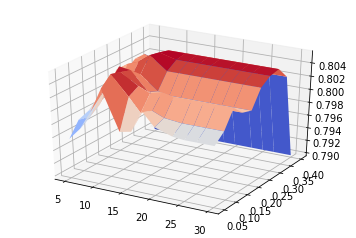

In [149]:
# Search best hyper-parameters and plot AUC
list_max_depth = np.linspace(5, 30, 12, dtype=int)
list_min_leaf = np.linspace(0.4, 0.05, 10)

max_depth_opt, min_leaf_opt = search_hyperparams_by_kfold(dtc, list_max_depth, list_min_leaf, X_train, y_train, 10)

Summary:
1. When max_depth = $11$ and min_samples_split ratio is $0.089$, it yields the highest AUC which is $0.805$.
2. From the 3D plotting, we can see some other max_depth can also achieve similar AUC ($\approx 0.8$), when min_samples_split ratio is around $0.3$.
3. K-fold cross-validation is used to determine the best hyper-parameters. Here $K=10$.

#### (c) Re-train a decision tree on the entire training data using the optimal max depth and minimum number of samples from (b). What is the AUC on the test set?

In [150]:
# Train decision tree using tuned hyperparameters
auc_c = train_and_evaluate(dtc, max_depth_opt, min_leaf_opt, X_train, y_train, X_test, y_test)
print('After training on the entire training set using optimal parameters, the AUC on test set is %.3f' % auc_c)

After training on the entire training set using optimal parameters, the AUC on test set is 0.801


#### (d) Create a visualization of the top 3 levels of your decision tree using the optimal max depth and minimum number of samples.

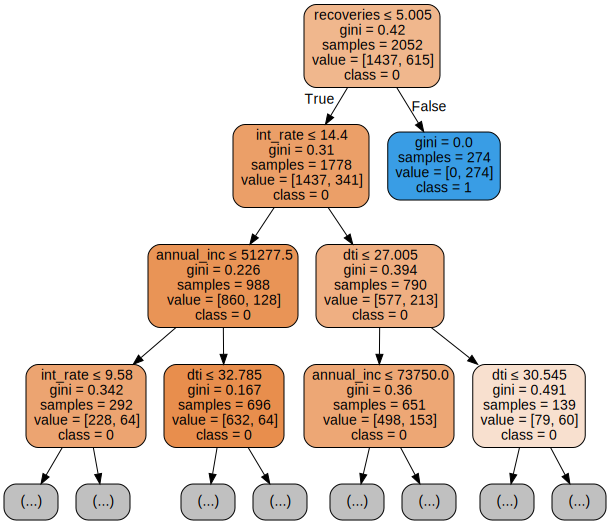

In [151]:
# Visualize decision tree
from sklearn import tree
import graphviz

feature_names = df.drop(columns='class').columns.tolist()
tree_visual = tree.export_graphviz(dtc, out_file=None, max_depth=3,
                                   feature_names=feature_names,
                                   class_names=['0', '1'],
                                   filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(tree_visual)
graph

#### (e) Analyze the effects of three different filtering methods (independently) on the decision tree. After filtering the variables, re-determine the optimal parameters and report the AUC on the test set as a direct comparison to part (c).
1. **Remove “highly” correlated variables. Note what metric you decide to use as correlation, and what your threshold for high is.**
2. **Rank the features based on the correlation criteria discussed in class. Based on the correlation results, justify your selection of the top k features.**
3. **Rank the features based on the mutual information criteria. Based on the results, justify your selection of the top k features.**

1. Filter out highly correlated variables.
    * Use the Pearson correlation coefficient matrix of features on training set: $R(x_i, x_j) = \dfrac{Cov(x_i, y)}{\sqrt{Var(x_i)Var(x_j)}}$
    * Remove features that have high correlation coefficients (above certain threshold) with others.
    * The threshold used here is $0.95$.

In [189]:
# Define method to filter out highly correlated features
def filter_highly_correlated_features(X_train, threshold):
    X_cov_abs_upper = np.absolute(np.triu(np.corrcoef(X_train, rowvar=False), k=1))
    col_to_remove = []
    for i in range(X_cov_abs_upper.shape[0]):
        if any(X_cov_abs_upper[:,i] > 0.95):
            col_to_remove.append(i)
    return np.delete(X_train, col_to_remove, axis=1), col_to_remove

In [190]:
# Apply method to filter out highly correlated features
X_train_f1, col_removed_f1 = filter_highly_correlated_features(X_train, 0.95)
print('After filtering out highly correlated features, the new training set has %d features.' % X_train_f1.shape[1])
print('The column indices of removed features are: ', end ="")
print(col_removed_f1)

After filtering out highly correlated features, the new training set has 35 features.
The column indices of removed features are: [3, 4]


The best AUC is 0.808 when max_depth = 11 and min_samples_split ratio is 0.283.


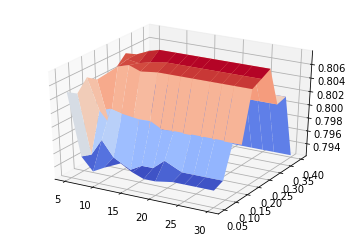

In [166]:
# Search hyper-parameters using new training set
max_depth_opt_f1, min_leaf_opt_f1 = search_hyperparams_by_kfold(dtc, list_max_depth, list_min_leaf, X_train_f1, y_train, 10)

In [167]:
# Train decision tree using new optimal hyperparameters
X_test_f1 = np.delete(X_test, col_removed_f1, axis=1)

auc_f1 = train_and_evaluate(dtc, max_depth_opt_f1, min_leaf_opt_f1, X_train_f1, y_train, X_test_f1, y_test)
print('Using filtering out highly correlated features, the AUC on test set is %.3f' % auc_f1)

Using filtering out highly correlated features, the AUC on test set is 0.809


2. Select features based on correlation criteria.
    * Rank features in order of their correlation with the labels: $R(x_d, y) = \dfrac{Cov(x_d, y)}{\sqrt{Var(x_d)Var(y)}}$
    * Select top k features. Here $k=31$ (justified below).

In [209]:
# Define method to compute correlation coefficients between features and target
def compute_corr_w_target(X_train, y_train):
    corr_coefs = []
    for i in range(X_train.shape[1]):
        tmp_matrix = np.vstack((X_train[:, i], y_train))
        corr_coefs.append((np.corrcoef(tmp_matrix))[0, 1])
    return np.array(corr_coefs)

In [215]:
# Print out absolute values of correlation coefficients by ASC order
corr_coefs_f2_abs = np.absolute(compute_corr_w_target(X_train, y_train))
np.sort(corr_coefs_f2_abs)

array([2.40874772e-05, 1.80411556e-03, 2.36671208e-03, 2.52985688e-03,
       2.82581210e-03, 2.96934384e-03, 5.39013350e-03, 9.72478562e-03,
       1.17551417e-02, 1.24153220e-02, 2.30782473e-02, 2.45239549e-02,
       2.54322806e-02, 2.69174055e-02, 2.73151348e-02, 3.01341438e-02,
       3.37069544e-02, 3.39086852e-02, 3.40713372e-02, 3.51753424e-02,
       3.56334744e-02, 5.21045316e-02, 5.44875448e-02, 6.34294072e-02,
       6.64510703e-02, 6.66296984e-02, 6.85205570e-02, 7.63032369e-02,
       8.25201776e-02, 8.61937275e-02, 1.07199330e-01, 1.25669017e-01,
       1.39999673e-01, 1.81235281e-01, 2.36437311e-01, 2.50341144e-01,
       4.51968145e-01])

By observation, there are $6$ features that have correlation coefficients with target $< 0.005$. Set the threshold as $0.005$.

In [226]:
# Get column indices with low correlation with target
col_to_remove_f2 = np.argwhere(corr_coefs_f2_abs < 5e-3)
print('The column indices of removed features are: ')
print(col_to_remove_f2)

# Filter out features/columns with low correlation with target
X_train_f2 = np.delete(X_train, col_to_remove_f2, axis=1)
X_test_f2 = np.delete(X_test, col_to_remove_f2, axis=1)

The column indices of removed features are: 
[[12]
 [18]
 [20]
 [27]
 [32]
 [36]]


Therefore, we select top $37 - 6 = 31$ features.

The best AUC is 0.805 when max_depth = 7 and min_samples_split ratio is 0.128.


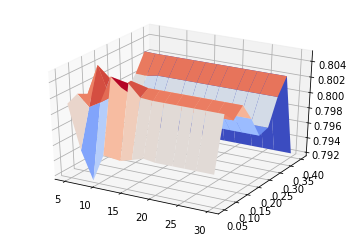

In [228]:
# Search hyper-parameters using new training set
max_depth_opt_f2, min_leaf_opt_f2 = search_hyperparams_by_kfold(dtc, list_max_depth, list_min_leaf, X_train_f2, y_train, 10)

In [229]:
# Train decision tree using new optimal hyperparameters
auc_f2 = train_and_evaluate(dtc, max_depth_opt_f2, min_leaf_opt_f2, X_train_f2, y_train, X_test_f2, y_test)
print('Using filtering out features with low correlation with target, the AUC on test set is %.3f' % auc_f2)

Using filtering out features with low correlation with target, the AUC on test set is 0.792


3. Select features based on mutual information criteria.
    * Rank features in order of mutual information criteria with target.
    * Select top k features. Here $k = 24$ (justified below).

In [233]:
# Print out values of mutual information with target
from sklearn.feature_selection import mutual_info_classif

mut_info_f3 = np.absolute(mutual_info_classif(X_train, y_train))
np.sort(mut_info_f3)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.76620025e-05, 3.25309792e-04,
       3.48941040e-04, 1.03065435e-03, 1.12959053e-03, 2.20962568e-03,
       2.63343992e-03, 3.02920213e-03, 3.27860709e-03, 4.57633154e-03,
       4.74258660e-03, 4.98652670e-03, 5.65060745e-03, 5.82281599e-03,
       6.07636396e-03, 6.75358567e-03, 6.87330081e-03, 7.57181774e-03,
       9.40026501e-03, 9.59132333e-03, 9.93257198e-03, 1.09597783e-02,
       2.02392093e-02, 2.03575118e-02, 2.18379643e-02, 5.03730226e-02,
       1.99057772e-01])

By observation, there are $13$ features that have mutual information with target $< 0.001$. Set the threshold as $0.001$.

In [237]:
# Get column indices with low mutual information with target
col_to_remove_f3 = np.argwhere(mut_info_f3 < 1e-3)
print('The column indices of removed features are: ')
print(col_to_remove_f3)

# Filter out features/columns with low mutual information with target
X_train_f3 = np.delete(X_train, col_to_remove_f3, axis=1)
X_test_f3 = np.delete(X_test, col_to_remove_f3, axis=1)

The column indices of removed features are: 
[[ 5]
 [ 6]
 [11]
 [14]
 [18]
 [19]
 [20]
 [22]
 [24]
 [26]
 [30]
 [33]
 [36]]


Therefore, we select top $37 - 13 = 24$ features.

The best AUC is 0.815 when max_depth = 7 and min_samples_split ratio is 0.050.


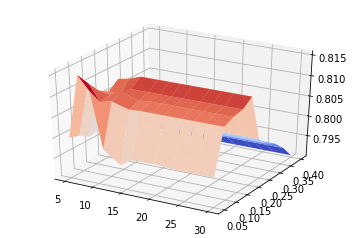

In [241]:
# Search hyper-parameters using new training set
max_depth_opt_f3, min_leaf_opt_f3 = search_hyperparams_by_kfold(dtc, list_max_depth, list_min_leaf, X_train_f3, y_train, 10)

In [242]:
# Train decision tree using new optimal hyperparameters
auc_f3 = train_and_evaluate(dtc, max_depth_opt_f3, min_leaf_opt_f3, X_train_f3, y_train, X_test_f3, y_test)
print('Using filtering out features with low mutual information with target, the AUC on test set is %.3f' % auc_f3)

Using filtering out features with low mutual information with target, the AUC on test set is 0.761


#### (f) Comment on the effect of features selection for decision trees based on your results from (c) and (e).

1. Filtering out highly correlated features yields similar AUC as no feature selection. It might be caused by only two features are filtered out when threshold is set to $0.95$, which isn't enough to cause significant impact on decision tree.
2. Filtering out features based on correlation criteria yields similar AUC on training set, and second-best AUC on test set. Because $6$ features are selected out, it causes slightly lower performance for decision tree.
3. Filtering out features based on mutual information criteria yields the highest AUC on training set, but lowest AUC on test set. Because $13$ features are selected out, some information is lost, and performance does downgrade a little bit.
4. Overall, even though some features are selected out, the AUC scores on test don't have huge difference, because the removed features are likely to have little correlation with target. In addition, the AUC result doesn't indicate which feature selection is better, because it depends on the threshold we choose.

## 3. Bootstrapping to Predict Loan Defaults
#### Use the pre-processed data you created from problem (2a).

#### (a) Train a ridge logistic regression model (use a standard toolkit) using all the training data you created. Specify how you choose the optimal parameter $\lambda$. How well does your model do on the test data?

In [253]:
# Define method to search best hyper-parameters
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

def search_lambda_by_kfold(lgr, lambdas, X, y, K):
    lambda_best = None
    auc_best = 0
    
    for lambda_ in lambdas:
        lgr.set_params(C=1/lambda_, warm_start=False)
        kf = KFold(n_splits=K)
        aucs = []
        for idx_train, idx_test in kf.split(X):
            X_train = X[idx_train]
            y_train = y[idx_train]
            X_valid = X[idx_test]
            y_valid = y[idx_test]
            
            lgr.fit(X_train, y_train)
            auc = roc_auc_score(y_valid, lgr.predict_proba(X_valid)[:, 1])
            aucs.append(auc)
            
        auc_mean = np.array(aucs).mean()
        if auc_mean > auc_best:
            auc_best = auc_mean
            lambda_best = lambda_
    
    return lambda_best, auc_best

In [254]:
# Standardize data
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [257]:
# Search best lambda
lgr = LogisticRegression(warm_start=False)
lambdas = np.logspace(-4, 1, 100)
lambda_best, auc_best = search_lambda_by_kfold(lgr, lambdas, X_train_std, y_train, 10)

In [259]:
# Train with best lambda and show AUC on test set
print('The best lambda is %.4f' % lambda_best)
lgr.set_params(C=1/lambda_best, warm_start=False)
lgr.fit(X_train_std, y_train)
auc = roc_auc_score(y_test, lgr.predict_proba(X_test_std)[:, 1])
print('Using best lambda, the AUC on test set is %.2f' % auc)

The best lambda is 0.0002
Using best lambda, the AUC on test set is 0.84


Summary:
* Standardize training and test set first.
* By using K-fold cross-validation ($K=10$) on training set, the best $\lambda=0.0002$, and the AUC on test set is $0.84$.

#### (b) Using 100 bootstrap samples, train 100 different ridge logistic regression models using all the training data you created. For ease, you will want to use the same $\lambda$ as (a). Compute the 95% confidence intervals for each coefficient estimate (you should have 26 for un-preprocessed data). Generate a plot that shoes the ridge regression estimates with error bars to denote the range (x-axis should be coefficient, y-axis should be value). How does it compare against the estimated parameters in (a)?

In [261]:
# Define method to train logistic regression models with bootstrapping
from sklearn.utils import resample

def train_lgr_bootstrapping(lambda_, X_train, y_train, sample_times):
    lgrs = []
    C = 1/lambda_
    for i in range(sample_times):
        idx_sampling = resample(np.arange(y_train.shape[0]))
        X_sampling = X_train[idx_sampling]
        y_sampling = y_train[idx_sampling]
        
        lgr = LogisticRegression(C=C)
        lgr.fit(X_sampling, y_sampling)
        lgrs.append(lgr)
    return lgrs

In [262]:
# Train logistic regression models with best lambda and bootstrapping
sample_times = 100
lgr_btr = train_lgr_bootstrapping(lambda_best, X_train_std, y_train, sample_times)

In [267]:
# Construct coefficient arrays
arr_coef = []
for i in range(sample_times):
    arr_coef.append(lgr_btr[i].coef_.reshape(-1))
arr_coef = np.array(arr_coef)
arr_coef.shape

(100, 37)

In [271]:
# Get 2.5% and 97.5% percentile coefficients
alpha = 95
coef_percentile = np.percentile(arr_coef, [(100-alpha)/2, 100 - (100-alpha)/2], axis=0)

In [ ]:
# Get confidence interval of coefficients
conf_itv = coef_percentile.T


#### (c) Using your 100 bootstrap models, generate the estimated prediction by (1) averaging the predicted response, and (2) averaging the predicted probabilities. What are the AUCs for the averaged versions? How does it compare to (a)?

In [313]:
# Define method to get AUC using prediction by averaging predicted response
def compute_auc_using_prediction_by_voting(lgrs, X_test, y_test):
    y_predicted = []
    for i in range(len(lgrs)):
        y_predicted.append(lgrs[i].predict(X_test))
    y_predicted = np.array(y_predicted)
    
    y_pos_cnt = np.count_nonzero(y_predicted, axis=0).reshape(-1)
    threshold = len(lgrs) // 2
    y_voted = np.where(y_pos_cnt > threshold, 1, 0)
    y_prob = y_pos_cnt / len(lgrs)
    
    auc = roc_auc_score(y_test, y_prob)
    return y_voted, auc

In [314]:
# Define method to get AUC using prediction by average predicted probabilities
def compute_auc_using_prediction_by_averaging_prob(lgrs, X_test, y_test):
    y_predicted_prob = []
    for i in range(len(lgrs)):
        y_predicted_prob.append(lgrs[i].predict_proba(X_test)[:, 1])
    y_predicted_prob = np.array(y_predicted_prob)
    
    y_prob = np.mean(y_predicted_prob, axis=0)
    y_averaged = np.where(y_prob > 0.5, 1, 0)
    
    auc = roc_auc_score(y_test, y_prob)
    return y_averaged, auc

In [315]:
y_avg_response, auc_avg_response = compute_auc_using_prediction_by_voting(lgr_btr, X_test_std, y_test)
y_avg_prob, auc_avg_prob = compute_auc_using_prediction_by_averaging_prob(lgr_btr, X_test_std, y_test)

print('The AUC by averaging response is %.3f' % auc_avg_response)
print('The AUC by averaging probabilities is %.3f' % auc_avg_prob)

The AUC by averaging response is 0.777
The AUC by averaging probabilities is 0.836


* By averaging the predicted probabilities from bootstrap models, it achieves similar AUC score as that from the single model from (a). Both AUC scores are around $0.84$.
* By averaging the predicted response (voting), its AUC on test set is lower than that from the single model from (a), and is also lower than that from averaging predicted probabilities.

#### (d) Comment on the effect of bootstrapping on the predictive performance based on the results from (a) and (c).

1. By using bootstrapping and averaged predicted prabability, the performance is similar to that from non-bootstrapping model for this problem.
2. In theory, using bootstrapping should help with lowering the variance if the sampling time is large enough. However, it does come with some computational price, since we need to sample data and train models multiple times.
3. Averaged response (voting) is not a good prediction compared to averaged probabilities, or single non-boostrapping model. It is because information about certainty is lost when each model votes.

## 4. Stochastic Gradient Tree Boosting to Predict Appliance Energy Usage
#### Consider the Energy dataset (energydata.zip) from Homework #1. As a reminder, each sample contains measurements of temperature and humidity sensors from a wireless network, weather from a nearby airport station, and the recorded energy use of lighting fixtures to predict the energy consumption of appliances in a low energy house. For this problem, you will implement a variant of stochastic gradient tree boost to predict the energy usage. There are two major changes from the gradient tree boosting algorithm that was discussed in class that each model is dampened by a factor $\nu$ ((i.e., model prediction is $y^t = y^{t-1} + \nu f_t(x_i)$), and there is random subsampling of the dataset (hence the name stochastic).

#### (a) Implement the stochastic gradient tree boosting algorithm (see Algorithm 1) using an existing decision tree implementation. Your boosting model should support the following parameters:
* **M: number of boosting iterations**
* **$\nu$: shrinkage parameter**
* **q: subsampling rate**

**Algorithm 1**
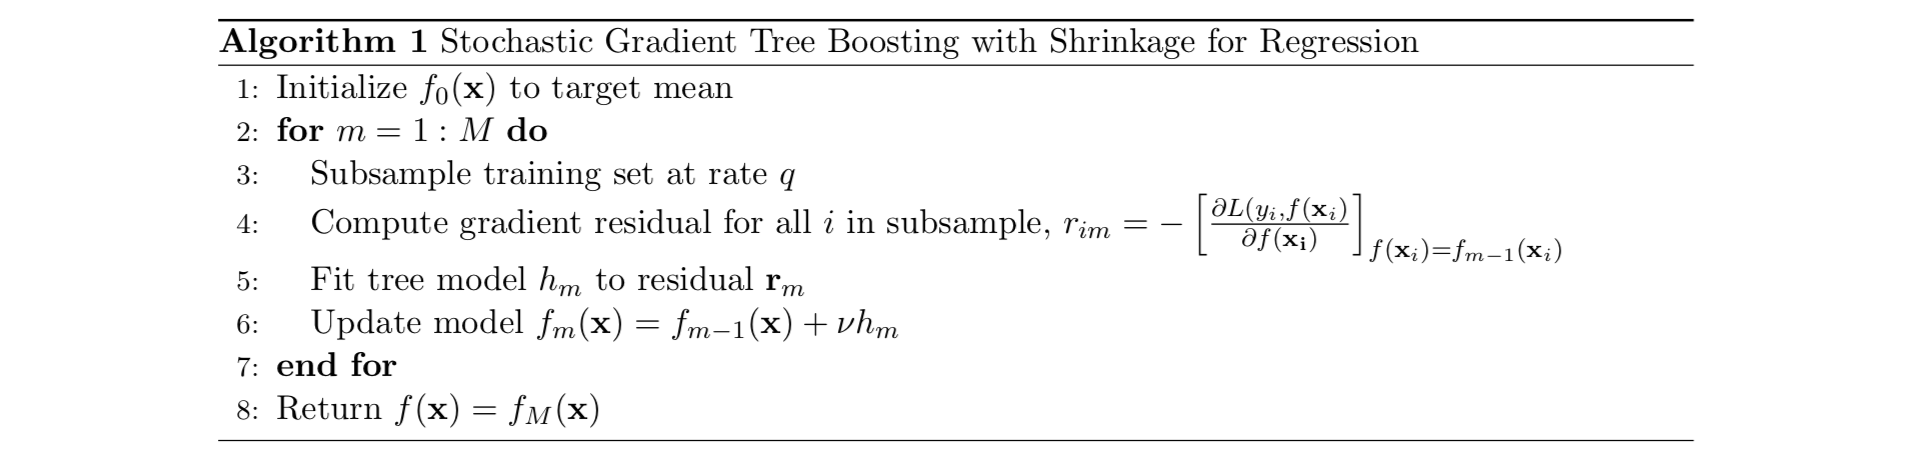